# Face detection model using YOLO.
### Data Collection:
I curated a dataset by extracting images from Google Images searches to capture a wide range of image variations.

The classes are from soccer players: Messi, Neymar e Cristiano Ronaldo

### Annotation:
I used Label Studio to label the dataset, carefully drawing bounding boxes around each instance of the target objects. This provided high-quality annotations for training.

In [1]:
!unzip -q /content/data2.zip -d /content/custom_data

Dataset Split: I used a script from Edje Electronics to automatically split the dataset into training and validation sets, ensuring a balanced distribution of images across classes.


In [2]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-08-24 22:32:26--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-08-24 22:32:26 (38.5 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 192
Number of annotation files: 192
Images moving to train: 172
Images moving to validation: 20


I have used ultralytics to make all operations.

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00


I used a Colab script from Edje Electronics to automatically generate the .yaml file required by YOLO. This file specified the dataset paths, class names, and number of classes, making it possible to run training with Ultralytics YOLO.

In [4]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 3
names:
- Cristiano Ronaldo
- Messi
- Neymar


Model Training: Trained a YOLO11s model using the Ultralytics framework for 60 epochs with an input size of 640×640 pixels, starting from pretrained weights to optimize accuracy.

In [5]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.185 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_widt

Then I did the model validation.

During validation, there was an image with an error: Neymar’s label was assigned to another person.

This happened because the training set didn’t have enough images, and most of them contained only one person.

In [6]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.185 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/20 /content/data/validation/images/2c5384ab-images_-_2025-08-24T170600.551.jpeg: 384x640 1 Cristiano Ronaldo, 1 Messi, 1 Neymar, 82.3ms
image 2/20 /content/data/validation/images/35e20141-images_-_2025-08-24T170234.652.jpeg: 384x640 1 Cristiano Ronaldo, 10.9ms
image 3/20 /content/data/validation/images/36e6e3f1-images_-_2025-08-24T170745.504.jpeg: 384x640 1 Cristiano Ronaldo, 14.2ms
image 4/20 /content/data/validation/images/542bc730-images_85.jpeg: 384x640 1 Messi, 13.0ms
image 5/20 /content/data/validation/images/57df095e-images_47.jpeg: 384x640 1 Neymar, 12.8ms
image 6/20 /content/data/validation/images/6572d55f-images_67.jpeg: 384x640 1 Neymar, 10.8ms
image 7/20 /content/data/validation/images/67129173-images_-_2025-08-24T170301.666.jpeg: 480x640 1 Cristiano Ronaldo, 89.6ms
image 8/20 /content/data/validation

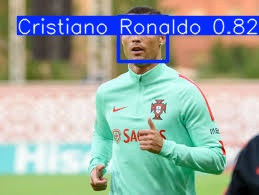

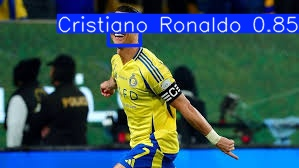

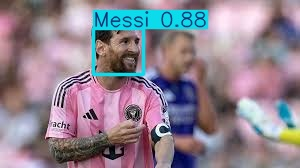

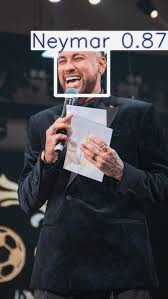

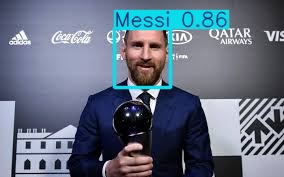

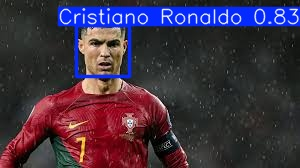

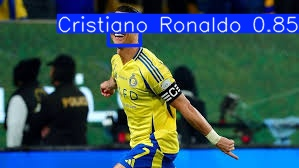

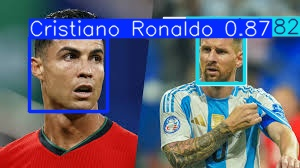

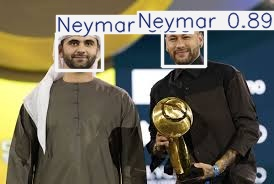

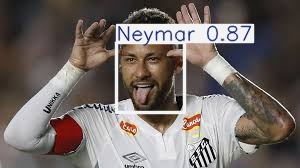

In [7]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')